In [3]:
import os

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch
from work.utils.models import EfficientNet
from skimage.io import imread
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

In [4]:
backbone_model = 'efficientnet-b0'
pretrained_model = {
    backbone_model: '../models/efficientnet-b0-08094119.pth'
}
data_dir = '../dataset'
images_dir = os.path.join(data_dir, 'tiles')

# df_train = pd.read_csv(f"../work/data/train_5fold.csv")

In [15]:
device = torch.device("cpu")
print("Using device:", device)
output_classes=5

Using device: cpu


In [16]:
model = EfficientNet(
    backbone=backbone_model,
    output_dimensions=output_classes,
    pre_trained_model=pretrained_model
)
model.load_state_dict(
    torch.load(
        "../models/with-noise-rgb.pth",
        weights_only=True,
        map_location=device
    )
)
model.to(device)

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (efficient_net): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSame

In [18]:
transform = transforms.Compose([transforms.ToTensor()])
# plt.imshow(image)

In [19]:
grad_cam = GradCAM(model=model, target_layers=[model.efficient_net._blocks[-1]])

In [20]:
def get_image_grad_cam(image):
    image_tensor = transform(image).unsqueeze(0)
    output = model(image_tensor)
    prediction = output.sigmoid()
    class_idx = int(prediction.sum(1).detach().round()) - 1

    # target = ClassifierOutputTarget(class_idx)

    # grads = grad_cam(input_tensor=image_tensor, targets=[target])
    grads = grad_cam(input_tensor=image_tensor)
    cam_image = grads[0]

    cam_image = np.maximum(cam_image, 0)
    cam_image = 1- (cam_image / cam_image.max())

    image_rgb = image / 255.0
    return image_rgb, cam_image

/tmp/ipykernel_868708/634625627.py:14: RuntimeWarning: invalid value encountered in divide
  cam_image = 1- (cam_image / cam_image.max())
/home/woshington/Projects/Doutorado/venv/lib/python3.10/site-packages/pytorch_grad_cam/utils/image.py:50: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)


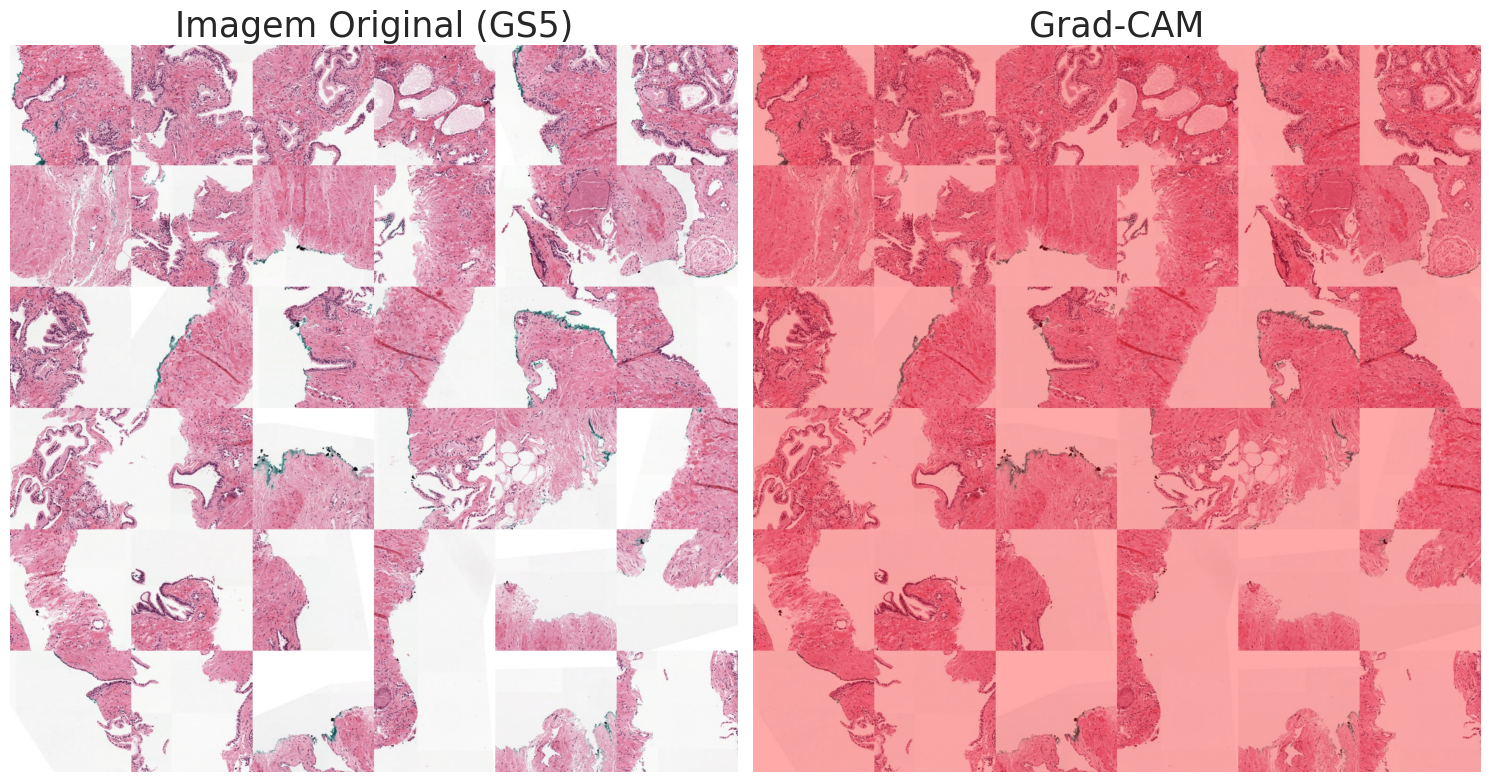

In [21]:
image = imread("../../../dataset/tiles/5af447057c0eb2ca945c12c398f670f9.jpg")
image_rgb, cam_image = get_image_grad_cam(image)
visualization = show_cam_on_image(image_rgb, cam_image, colormap=cv2.COLORMAP_JET, use_rgb=False)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))  # 1 linha, 2 colunas

ax[0].imshow(image_rgb)
ax[0].set_title("Imagem Original (GS5)", fontsize=25)
ax[0].axis('off')

ax[1].imshow(visualization)
ax[1].set_title("Grad-CAM", fontsize=25)
ax[1].axis('off')

plt.tight_layout()
plt.title="GS5 classificada como Benigno"
plt.savefig("grad-cam.png")
plt.show()

In [ ]:

image = imread("../../../dataset/tiles/6d569809f11e6e53918dfb1609fb0d83.jpg")

image_rgb, cam_image = get_image_grad_cam(image)
visualization = show_cam_on_image(image_rgb, cam_image, colormap=cv2.COLORMAP_JET, use_rgb=False)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))  # 1 linha, 2 colunas

ax[0].imshow(image_rgb)
ax[0].set_title("Original (GS5)", fontsize=25)
ax[0].axis('off')

ax[1].imshow(visualization)
ax[1].set_title("Grad-CAM", fontsize=25)
ax[1].axis('off')

plt.tight_layout()
plt.savefig("grad-cam-gs5.png")
plt.show()